In [1]:
# Cell 1: Installations
!pip install -U transformers==4.53.2
!pip install -U accelerate
!pip install -U bitsandbytes

!pip install flash-attn==2.7.4.post1 \
  --extra-index-url https://download.pytorch.org/whl/cu124 \
  --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 123.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [2]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.8.3 requires cut_cross_entropy, which is not installed.
unsloth-zoo 2025.8.3 requires msgspec, which is not installed.
unsloth-zoo 2025.8.3 requires tyro, which is not installed.
trl 0.21.0 requires transformers>=4.55.0, but you have transformers 4.53.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.

In [3]:
import unsloth
from unsloth import FastModel
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from huggingface_hub import hf_hub_download
import json
import re
import math
import time

print("✅ All modules imported.")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ All modules imported.


In [4]:
# ===================================================================
# 1. DEFINE CUSTOM CLASSIFIER (Required for Phi-4)
# ===================================================================
class GPTSequenceClassifier(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base = base_model
        hidden_size = base_model.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels, bias=True)
        self.num_labels = num_labels

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, **kwargs)
        last_hidden_state = outputs.hidden_states[-1]
        pooled_output = last_hidden_state[:, -1, :]
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = nn.functional.cross_entropy(logits.view(-1, self.num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [5]:
# ===================================================================
# 2. LOAD MODELS AND TOKENIZERS
# ===================================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Model 1: Equation Extractor (Gemma-3 with Unsloth) ---
print("\nLoading Equation Extraction Model...")
extractor_adapter_repo = "arvindsuresh-math/gemma-3-1b-equation-extractor-lora"
base_gemma_model = "unsloth/gemma-3-1b-it-unsloth-bnb-4bit"

gemma_model, gemma_tokenizer = FastModel.from_pretrained(
    model_name=base_gemma_model,
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

# --- Gemma tokenizer hygiene (fix the right-padding warning) ---
if gemma_tokenizer.pad_token is None:
    gemma_tokenizer.pad_token = gemma_tokenizer.eos_token
gemma_tokenizer.padding_side = "left"   # align last tokens across the batch

gemma_model = PeftModel.from_pretrained(gemma_model, extractor_adapter_repo)
print("✅ Equation Extraction Model loaded.")


# --- Model 2: Conceptual Error Classifier (Phi-4) ---
print("\nLoading Conceptual Error Classifier Model...")
classifier_adapter_repo = "arvindsuresh-math/phi-4-error-binary-classifier"
base_phi_model = "microsoft/Phi-4-mini-instruct"

DTYPE = torch.bfloat16
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=DTYPE
    )
classifier_backbone_base = AutoModelForCausalLM.from_pretrained(
    base_phi_model,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
    )

classifier_tokenizer = AutoTokenizer.from_pretrained(
    base_phi_model,
    trust_remote_code=True
    )
classifier_tokenizer.padding_side = "left"
if classifier_tokenizer.pad_token is None:
    classifier_tokenizer.pad_token = classifier_tokenizer.eos_token

classifier_backbone_peft = PeftModel.from_pretrained(
    classifier_backbone_base,
    classifier_adapter_repo
    )
classifier_model = GPTSequenceClassifier(classifier_backbone_peft, num_labels=2)

# Download and load the custom classifier head's state dictionary
classifier_head_path = hf_hub_download(repo_id=classifier_adapter_repo, filename="classifier_head.pth")
classifier_model.classifier.load_state_dict(torch.load(classifier_head_path, map_location=device))

classifier_model.to(device)
classifier_model = classifier_model.to(torch.bfloat16)

classifier_model.eval() # Set model to evaluation mode
print("✅ Conceptual Error Classifier Model loaded.")

Using device: cuda

Loading Equation Extraction Model...
==((====))==  Unsloth 2025.8.4: Fast Gemma3 patching. Transformers: 4.53.2.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


<string>:36: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.


model.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

✅ Equation Extraction Model loaded.

Loading Conceptual Error Classifier Model...


config.json: 0.00B [00:00, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/92.3M [00:00<?, ?B/s]

classifier_head.pth:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

✅ Conceptual Error Classifier Model loaded.


In [6]:
# --- Prompts ---

# --- Prompts ---
EXTRACTOR_SYSTEM_PROMPT = \
"""[ROLE]
You are an expert at parsing mathematical solutions.
[TASK]
You are given a mathematical solution. Your task is to extract the calculation performed on each line and represent it as a simple equation.
**This is a literal transcription task. Follow these rules with extreme precision:**
- **RULE 1: Transcribe EXACTLY.** Do not correct mathematical errors. If a line implies `2+2=5`, your output for that line must be `2+2=5`.
- **RULE 2: Isolate the Equation.** Your output must contain ONLY the equation. Do not include any surrounding text, units (like `/hour`), or currency symbols (like `$`).
- **RULE 3: Use Standard Operators.** Always use `*` for multiplication. Never use `x`.
[RESPONSE FORMAT]
Your response must be ONLY a single, valid JSON object, adhering strictly to these rules:
For each line of the solution, create a key-value pair.
- The key should be the line identifier (e.g., "L1", "L2", "FA" for the final answer line).
- The value should be the extracted equation string (e.g., "10+5=15").
- If a line contains no calculation, the value must be an empty string.
"""

CLASSIFIER_SYSTEM_PROMPT = \
"""You are a mathematics tutor.
You will be given a math word problem and a solution written by a student.
Carefully analyze the problem and solution LINE-BY-LINE and determine whether there are any errors in the solution."""

# --- Example 1 ---
FEW_SHOT_EXAMPLE_1_SOLUTION = {
  "L1": "2% of $90 is (2/100)*$90 = $1.8",
  "L2": "2% of $60 is (2/100)*$60 = $1.2",
  "L3": "The second transaction was reversed without the service charge so only a total of $90+$1.8+$1.2 = $39 was deducted from his account",
  "L4": "He will have a balance of $400-$39 = $361",
  "FA": "361"
}

FEW_SHOT_EXAMPLE_1_EQUATIONS = {
  "L1": "(2/100)*90=1.8",
  "L2": "(2/100)*60=1.2",
  "L3": "90+1.8+1.2=39",
  "L4": "400-39=361",
  "FA": ""
}


# --- Example 2 ---
FEW_SHOT_EXAMPLE_2_SOLUTION = {
  "L1": "She drinks 2 bottles a day and there are 24 bottles in a case so a case will last 24/2 = 12 days",
  "L2": "She needs enough to last her 240 days and 1 case will last her 12 days so she needs 240/12 = 20 cases",
  "L3": "Each case is on sale for $12.00 and she needs 20 cases so that's 12*20 = $240.00",
  "FA": "240"
}

FEW_SHOT_EXAMPLE_2_EQUATIONS = {
  "L1": "24/2=12",
  "L2": "240/12=20",
  "L3": "12*20=240.00",
  "FA": ""
}

def create_extractor_messages(solution_json_str: str) -> list:
    """
    Returns a list of dictionaries representing the conversation history for the prompt.
    """
    # Start with the constant few-shot examples defined globally
    messages = [
        {"role": "user", "content": f"{EXTRACTOR_SYSTEM_PROMPT}\n\n### Solution:\n{json.dumps(FEW_SHOT_EXAMPLE_1_SOLUTION, indent=2)}"},
        {"role": "assistant", "content": json.dumps(FEW_SHOT_EXAMPLE_1_EQUATIONS, indent=2)},
        {"role": "user", "content": f"### Solution:\n{json.dumps(FEW_SHOT_EXAMPLE_2_SOLUTION, indent=2)}"},
        {"role": "assistant", "content": json.dumps(FEW_SHOT_EXAMPLE_2_EQUATIONS, indent=2)},
    ]

    # Add the final user query to the end of the conversation
    final_user_prompt = f"### Solution:\n{solution_json_str}"
    messages.append({"role": "user", "content": final_user_prompt})

    return messages

In [7]:
# --- Helper Functions ---
def format_solution_into_json_str(solution_text: str) -> str:
    lines = [line.strip() for line in solution_text.strip().split('\n') if line.strip()]
    final_answer = ""
    if lines and "FINAL ANSWER:" in lines[-1].upper():
        final_answer = lines[-1][len("FINAL ANSWER:"):].strip()
        lines = lines[:-1]
    solution_dict = {f"L{i+1}": line for i, line in enumerate(lines)}
    solution_dict["FA"] = final_answer
    return json.dumps(solution_dict, indent=2)

def sanitize_equation_string(expression: str) -> str:
    if not isinstance(expression, str):
        return ""

    s = expression.strip()

    # Normalize common symbols
    s = s.replace('×', '*').replace('·', '*').replace('x', '*')

    # Convert percentages like '12%' -> '(12/100)'
    s = re.sub(r'(?<!\d)(\d+(?:\.\d+)?)\s*%', r'(\1/100)', s)

    # Simple paren balancing trims (only when a single stray exists at an edge)
    if s.count('(') > s.count(')') and s.startswith('('):
        s = s[1:]
    elif s.count(')') > s.count('(') and s.endswith(')'):
        s = s[:-1]

    # Drop units right after a slash: /hr, /dogs
    s = re.sub(r'/([a-zA-Z]+)', '', s)

    # Keep only numeric math tokens
    s = re.sub(r'[^\d.()+\-*/=%]', '', s)

    # Collapse repeated '=' (e.g., '==24/2=12' -> '=24/2=12')
    s = re.sub(r'=+', '=', s)

    return s

import re, math

def _parse_equation(eq_str: str):
    s = sanitize_equation_string(eq_str or "")
    s = s.lstrip('=')  # handle lines like '=24/2=12'
    if '=' not in s:
        return None
    if s.count('=') > 1:
        pos = s.rfind('=')
        lhs, rhs = s[:pos], s[pos+1:]
    else:
        lhs, rhs = s.split('=', 1)
    lhs, rhs = lhs.strip(), rhs.strip()
    if not lhs or not rhs:
        return None
    return lhs, rhs

def _abs_tol_from_display(rhs_str: str):
    """
    If RHS is a single numeric literal like 0.33, use half-ULP at that precision.
    e.g., '0.33' -> 0.5 * 10^-2 = 0.005
    Otherwise return None and fall back to base tolerances.
    """
    s = rhs_str.strip()
    # allow optional parens and sign
    m = re.fullmatch(r'\(?\s*[-+]?\d+(?:\.(\d+))?\s*\)?', s)
    if not m:
        return None
    frac = m.group(1) or ""
    d = len(frac)
    return 0.5 * (10 ** (-d)) if d > 0 else 0.5  # if integer shown, allow ±0.5

def evaluate_equations(eq_dict: dict, sol_dict: dict,
                       base_rel_tol: float = 1e-6,
                       base_abs_tol: float = 1e-9,
                       honor_display_precision: bool = True):
    """
    Evaluates extracted equations. Accepts rounded RHS values based on displayed precision.
    """
    for key, eq_str in (eq_dict or {}).items():
        parsed = _parse_equation(eq_str)
        if not parsed:
            continue
        lhs, rhs_str = parsed

        try:
            lhs_val = eval(lhs, {"__builtins__": None}, {})
            rhs_val = eval(rhs_str, {"__builtins__": None}, {})
        except Exception:
            continue

        # dynamic absolute tolerance from RHS formatting (e.g., 0.33 -> 0.005)
        abs_tol = base_abs_tol
        if honor_display_precision:
            dyn = _abs_tol_from_display(rhs_str)
            if dyn is not None:
                abs_tol = max(abs_tol, dyn)

        if not math.isclose(lhs_val, rhs_val, rel_tol=base_rel_tol, abs_tol=abs_tol):
            correct_rhs_val = round(lhs_val, 6)
            correct_rhs_str = f"{correct_rhs_val:.6f}".rstrip('0').rstrip('.')
            return {
                "error": True,
                "line_key": key,
                "line_text": sol_dict.get(key, "N/A"),
                "original_flawed_calc": eq_str,
                "sanitized_lhs": lhs,
                "original_rhs": rhs_str,
                "correct_rhs": correct_rhs_str,
            }

    return {"error": False}





def extract_json_from_response(response: str) -> dict:
    """
    Recover equations from the extractor's output.

    Strategy:
      1) Try to parse a real JSON object (if present).
      2) Parse relaxed key-value lines like 'L1: ...' or 'FA=...'.
      3) Also fall back to linewise equations (e.g., '=24/2=12', '7*2=14') and
         merge them as L1, L2, ... preserving order. Keep FA if present.
    """
    out = {}

    if not response or not isinstance(response, str):
        return out

    text = response.strip()

    # --- 1) strict JSON block, if any ---
    m = re.search(r'\{.*\}', text, flags=re.S)
    if m:
        try:
            obj = json.loads(m.group(0))
            if isinstance(obj, dict) and any(k.startswith("L") for k in obj):
                return obj
            elif isinstance(obj, dict):
                out.update(obj)  # keep FA etc., then continue
        except Exception:
            pass

    # --- 2) relaxed key/value lines: Lk : value   or   FA = value ---
    relaxed = {}
    for ln in text.splitlines():
        ln = ln.strip().strip(',')
        if not ln:
            continue
        m = re.match(r'(?i)^(L\d+|FA)\s*[:=]\s*(.+?)\s*$', ln)
        if m:
            k = m.group(1).strip()
            v = m.group(2).strip().rstrip(',')
            relaxed[k] = v
    out.update(relaxed)

    # Count how many L-keys we already have
    existing_L = sorted(
        int(k[1:]) for k in out.keys()
        if k.startswith("L") and k[1:].isdigit()
    )
    next_L = (max(existing_L) + 1) if existing_L else 1

    # --- 3) linewise fallback: harvest bare equations and merge ---
    def _looks_like_equation(s: str) -> str | None:
        s = sanitize_equation_string(s or "").lstrip('=')
        if '=' in s and any(ch.isdigit() for ch in s):
            return s
        return None

    # set of existing equation strings to avoid duplicates
    seen_vals = set(v for v in out.values() if isinstance(v, str))

    for ln in text.splitlines():
        ln = ln.strip().strip(',')
        if not ln or re.match(r'(?i)^(L\d+|FA)\s*[:=]', ln):
            # skip lines we already captured as relaxed pairs
            continue
        eq = _looks_like_equation(ln)
        if eq and eq not in seen_vals:
            out[f"L{next_L}"] = eq
            seen_vals.add(eq)
            next_L += 1

    return out

########################## old functions below


def old_sanitize_equation_string(expression: str) -> str:
    """
    Enhanced version with your requested simplified parenthesis logic.
    """
    if not isinstance(expression, str):
        return ""

    # Your requested parenthesis logic:
    if expression.count('(') > expression.count(')') and expression.startswith('('):
        expression = expression[1:]
    elif expression.count(')') > expression.count('(') and expression.endswith(')'):
        expression = expression[:-1]

    sanitized = expression.replace(' ', '')
    sanitized = sanitized.replace('x', '*').replace('×', '*')
    sanitized = re.sub(r'/([a-zA-Z]+)', '', sanitized)
    sanitized = re.sub(r'[^\d.()+\-*/=]', '', sanitized)
    return sanitized




def old_evaluate_equations(eq_dict: dict, sol_dict: dict):
    """
    Evaluates extracted equations and returns a more detailed dictionary for
    building clearer explanations.
    """
    for key, eq_str in eq_dict.items():
        if not eq_str or "=" not in eq_str:
            continue
        try:
            sanitized_eq = sanitize_equation_string(eq_str)

            if not sanitized_eq or "=" not in sanitized_eq:
                continue

            lhs, rhs_str = sanitized_eq.split('=', 1)

            if not lhs or not rhs_str:
                continue

            lhs_val = eval(lhs, {"__builtins__": None}, {})
            rhs_val = eval(rhs_str, {"__builtins__": None}, {})

            if not math.isclose(lhs_val, rhs_val, rel_tol=1e-2):
                correct_rhs_val = round(lhs_val, 4)
                correct_rhs_str = f"{correct_rhs_val:.4f}".rstrip('0').rstrip('.')

                # Return a more detailed dictionary for better explanations
                return {
                    "error": True,
                    "line_key": key,
                    "line_text": sol_dict.get(key, "N/A"),
                    "original_flawed_calc": eq_str, # The raw model output
                    "sanitized_lhs": lhs,           # The clean left side
                    "original_rhs": rhs_str,        # The clean right side
                    "correct_rhs": correct_rhs_str, # The correct right side
                }
        except Exception:
            continue

    return {"error": False}



def old_extract_json_from_response(response: str) -> dict:
    """
    (old version that doesnt do well)
    Manually parses the model's output using regex instead of relying on
    perfectly-formed JSON. This is robust to syntax errors from the LLM.
    """
    # Regex to find all keys like "L1", "L2", "FA", etc.
    keys = re.findall(r'"(L\d+|FA)"\s*:', response)

    # Regex to find all values associated with the keys.
    # It looks for text enclosed in double quotes.
    values = re.findall(r':\s*"([^"]*)"', response)

    # If the number of keys and values doesn't match, something is very wrong.
    # This is a safety check.
    if len(keys) != len(values):
        # Fallback for cases where the format is extremely broken
        if not keys and not values:
            return {} # Truly empty
        # Try to at least salvage something if possible
        min_len = min(len(keys), len(values))
        return dict(zip(keys[:min_len], values[:min_len]))

    # Combine the extracted keys and values into a dictionary
    return dict(zip(keys, values))

def old_evaluate_equations(eq_dict: dict, sol_dict: dict, *, rel_tol=1e-6, abs_tol=1e-9):
    """
    Scan equations; return the first mismatch with details, else {"error": False}.
    """
    for key, eq_str in (eq_dict or {}).items():
        parsed = _parse_equation(eq_str)
        if not parsed:
            continue
        lhs, rhs_str = parsed
        try:
            lhs_val = eval(lhs, {"__builtins__": None}, {})
            rhs_val = eval(rhs_str, {"__builtins__": None}, {})
        except Exception:
            continue

        if not math.isclose(lhs_val, rhs_val, rel_tol=rel_tol, abs_tol=abs_tol):
            correct_rhs_val = round(lhs_val, 6)
            correct_rhs_str = f"{correct_rhs_val:.6f}".rstrip('0').rstrip('.')
            return {
                "error": True,
                "line_key": key,
                "line_text": sol_dict.get(key, "N/A"),
                "original_flawed_calc": eq_str,
                "sanitized_lhs": lhs,
                "original_rhs": rhs_str,
                "correct_rhs": correct_rhs_str,
            }

    return {"error": False}



# def extract_json_from_response(response: str) -> dict:
#     match = re.search(r'```json\s*(\{.*?\})\s*```', response, re.DOTALL)
#     json_str = match.group(1) if match else re.search(r'(\{.*?\})', response, re.DOTALL)
#     if not json_str: return {}
#     try:
#         return json.loads(json_str.group(0) if hasattr(json_str, 'group') else json_str)
#     except (json.JSONDecodeError, AttributeError): return {}

In [ ]:
def test_analysis_pipeline(math_question, proposed_solution):
    """
    Notebook version of the analysis pipeline for testing.
    Prints progress and returns a final dictionary.
    """
    print("-" * 50)
    print(f"Testing problem: {math_question[:50]}...")

    # --- STAGE 1: COMPUTATIONAL CHECK ---
    print("Step 1: Extracting equations...")
    solution_json_str = format_solution_into_json_str(proposed_solution)
    messages = [{"role": "user", "content": f"{EXTRACTOR_SYSTEM_PROMPT}\n\n### Solution:\n{solution_json_str}"}]
    gemma_tokenizer.padding_side = "left"
    prompt = gemma_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = gemma_tokenizer([prompt], return_tensors="pt").to(device)
    gemma_tokenizer.padding_side = "left"
    outputs = gemma_model.generate(
        **inputs,
        max_new_tokens=300,
        use_cache=True,
        pad_token_id=gemma_tokenizer.pad_token_id,
        do_sample=False,
        temperature=0.0,
    )
    gemma_tokenizer.padding_side = "left"

    extracted_text = gemma_tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0]
    extracted_eq_dict = extract_json_from_response(extracted_text)
    print(f"  > Extracted equations: {json.dumps(extracted_eq_dict)}")

    computational_error = evaluate_equations(extracted_eq_dict, json.loads(solution_json_str))

    if computational_error["error"]:
        explanation = (
            f"A computational error was found.\n"
            f"On line: \"{computational_error['line_text']}\"\n"
            f"The calculation was: {computational_error['flawed_calc']}\n"
            f"The correct calculation should be: {computational_error['correct_calc']}"
        )
        return {"classification": "Computational Error", "confidence": "100%", "explanation": explanation}

    # --- STAGE 2: CONCEPTUAL CHECK ---
    print("\nStep 2: Checking for conceptual errors...")
    input_text = f"{CLASSIFIER_SYSTEM_PROMPT}\n\n### Problem:\n{math_question}\n\n### Answer:\n{proposed_solution}"
    inputs = classifier_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = classifier_model(**inputs)
        logits = outputs["logits"]
        probs = torch.softmax(logits, dim=-1).squeeze().tolist()
        print(f"  > Raw probabilities [Correct, Flawed]: {probs}")

    is_flawed_prob = probs[1]
    is_correct_prob = probs[0]

    if is_flawed_prob > 0.5:
        return {"classification": "Conceptual Error", "confidence": f"{is_flawed_prob:.2%}", "explanation": "Logic or setup appears to have a conceptual error."}
    else:
        return {"classification": "Correct", "confidence": f"{is_correct_prob:.2%}", "explanation": "Solution appears correct."}

In [ ]:
def debug_analysis_pipeline(math_question, proposed_solution):
    """
    (Complete, Refactored Version)
    Orchestrates the pipeline by calling helper functions and printing the
    inputs/outputs at each stage for clear debugging.
    """
    print("="*80)
    print(f"🕵️  STARTING DEBUG FOR: {math_question[:60]}...")
    print("="*80)

    # ===================================================================
    # --- STAGE 1: COMPUTATIONAL CHECK (GEMMA MODEL) ---
    # ===================================================================
    stage1_start_time = time.monotonic()
    print("\n--- STAGE 1: Equation Extraction (Gemma) ---")

    # [1.1] Format the solution
    print("\n[1.1] Calling format_solution_into_json_str...")
    solution_json_str = format_solution_into_json_str(proposed_solution)
    solution_dict = json.loads(solution_json_str)
    print("  > Output:")
    print(solution_json_str)

    # [1.2] Build the message list using the new helper function
    print("\n[1.2] Calling create_extractor_messages...")
    messages = create_extractor_messages(solution_json_str)
    print(f"  > Output: Generated a list of {len(messages)} messages.")

    # [1.3] Apply the chat template to create the full prompt string
    prompt = gemma_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("\n[1.3] Full Prompt for Gemma Model (with few-shot examples):")
    print("--------------------")
    print(prompt)
    print("--------------------")

    # [1.4] Run inference with the Gemma model
    inputs = gemma_tokenizer([prompt], return_tensors="pt").to(device)

    outputs = gemma_model.generate(
        **inputs,
        max_new_tokens=300,
        use_cache=True,
        pad_token_id=gemma_tokenizer.pad_token_id,
        do_sample=False,
        temperature=0.0,
    )


    extracted_text = gemma_tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0]

    print("\n[1.4] Raw Text Output from Gemma Model:")
    print("--------------------")
    print(extracted_text)
    print("--------------------")

    # [1.5] Parse the raw text using the robust regex-based function
    print("\n[1.5] Calling extract_json_from_response...")
    extracted_eq_dict = extract_json_from_response(extracted_text)
    print("  > Output (Parsed JSON dict):")
    print(json.dumps(extracted_eq_dict, indent=2))

    # [1.6] Filter out equations for lines that contain no digits
    print("\n[1.6] Filtering out equations for non-numeric lines:")
    final_eq_to_eval = {}
    for key, eq_str in extracted_eq_dict.items():
        original_line = solution_dict.get(key, "")
        if any(char.isdigit() for char in original_line):
            final_eq_to_eval[key] = eq_str
        else:
            print(f"  > Line '{key}' has no digits. Discarding extracted equation: '{eq_str}'")
    print("  > Final equations to be evaluated:", json.dumps(final_eq_to_eval, indent=2))

    # [1.7] Evaluate the final, filtered set of equations
    print("\n[1.7] Calling evaluate_equations...")
    computational_error = evaluate_equations(final_eq_to_eval, solution_dict)
    stage1_end_time = time.monotonic()
    print(f"  > Output (Latency: {stage1_end_time - stage1_start_time:.2f}s):")
    print(f"  > {computational_error}")

    # [1.8] Check the result and exit if a computational error was found
    if computational_error["error"]:
        print("\n  > 🔴 Error Found!")
        lhs, rhs, correct_rhs = computational_error['sanitized_lhs'], computational_error['original_rhs'], computational_error['correct_rhs']
        explanation = f"A computational error was found.\nOn line: \"{computational_error['line_text']}\"\nThe student wrote '{lhs} = {rhs}', but the correct result of '{lhs}' is {correct_rhs}."
        final_result = {"classification": "Computational Error", "confidence": "100%", "explanation": explanation}
        print("\n" + "="*80)
        print(f"🏁 FINAL RESULT: {final_result['classification']}")
        print("="*80 + "\n\n")
        return final_result
    else:
        print("\n  > ✅ All calculations are correct. Proceeding to Stage 2.")

    # ===================================================================
    # --- STAGE 2: CONCEPTUAL CHECK (PHI-4 MODEL) ---
    # ===================================================================
    stage2_start_time = time.monotonic()
    print("\n\n--- STAGE 2: Conceptual Check (Phi-4) ---")

    # [2.1] Create the prompt for the Phi-4 model
    input_text = f"{CLASSIFIER_SYSTEM_PROMPT}\n\n### Problem:\n{math_question}\n\n### Answer:\n{proposed_solution}"
    print("\n[2.1] Full Prompt for Phi-4 Model:")
    print("--------------------")
    print(input_text)
    print("--------------------")

    # [2.2] Run inference with the Phi-4 model
    inputs = classifier_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = classifier_model(**inputs)
        logits = outputs["logits"]
        probs = torch.softmax(logits, dim=-1).squeeze().tolist()

    # [2.3] Display the model's raw outputs
    print(f"\n[2.3] Raw Logits from Phi-4 Model: {logits.to(torch.float32).cpu().numpy()}")
    print(f"\n[2.4] Softmax Probabilities [Correct, Flawed]: {probs}")

    # [2.5] Determine the final classification based on the probabilities
    stage2_end_time = time.monotonic()
    print(f"\n[2.5] Final Decision Logic (Latency: {stage2_end_time - stage2_start_time:.2f}s):")

    is_flawed_prob = probs[1]
    is_correct_prob = probs[0]

    if is_flawed_prob > 0.5:
        print(f"  > Flawed probability ({is_flawed_prob:.2%}) is > 50%.")
        final_result = {"classification": "Conceptual Error", "confidence": f"{is_flawed_prob:.2%}", "explanation": "Logic or setup appears to have a conceptual error."}
    else:
        print(f"  > Correct probability ({is_correct_prob:.2%}) is > 50%.")
        final_result = {"classification": "Correct", "confidence": f"{is_correct_prob:.2%}", "explanation": "Solution appears correct."}

    print("\n" + "="*80)
    print(f"🏁 FINAL RESULT: {final_result['classification']}")
    print("="*80 + "\n\n")
    return final_result

In [ ]:
test_cases = [
    {
        "name": "Computational Error",
        "question": "John has three apples and Mary has seven, how many apples do they have together?",
        "solution": "They have 7 + 3 = 11 apples.\nFINAL ANSWER: 11"
    },
    {
        "name": "Correct Solution",
        "question": "A grocery store sells apples for $0.50 each and oranges for $0.75 each. If a customer buys 10 apples and 5 oranges, what is the total cost?",
        "solution": "Apple cost: 10 * 0.50 = 5.00\nOrange cost: 5 * 0.75 = 3.75\nTotal cost: 5.00 + 3.75 = 8.75\nFINAL ANSWER: 8.75"
    },
    {
        "name": "Conceptual Error",
        "question": "A car travels at 60 miles per hour. How long will it take to travel 180 miles?",
        "solution": "Time = Speed / Distance\nTime = 60 / 180 = 0.33 hours\nFINAL ANSWER: 0.33"
    }
]

for test in test_cases:
    result = debug_analysis_pipeline(test["question"], test["solution"])
    print("\n--- FINAL RESULT ---")
    print(f"Case: {test['name']}")
    print(f"Classification: {result['classification']}")
    print(f"Confidence: {result['confidence']}")
    print(f"Explanation: {result['explanation']}")
    print("="*50 + "\n")

🕵️  STARTING DEBUG FOR: John has three apples and Mary has seven, how many apples do...

--- STAGE 1: Equation Extraction (Gemma) ---

[1.1] Calling format_solution_into_json_str...
  > Output:
{
  "L1": "They have 7 + 3 = 11 apples.",
  "FA": "11"
}

[1.2] Calling create_extractor_messages...
  > Output: Generated a list of 5 messages.

[1.3] Full Prompt for Gemma Model (with few-shot examples):
--------------------
<bos><start_of_turn>user
[ROLE]
You are an expert at parsing mathematical solutions.
[TASK]
You are given a mathematical solution. Your task is to extract the calculation performed on each line and represent it as a simple equation.
**This is a literal transcription task. Follow these rules with extreme precision:**
- **RULE 1: Transcribe EXACTLY.** Do not correct mathematical errors. If a line implies `2+2=5`, your output for that line must be `2+2=5`.
- **RULE 2: Isolate the Equation.** Your output must contain ONLY the equation. Do not include any surrounding text, unit

In [8]:
import pandas as pd
from tqdm.notebook import tqdm
import time
import json
import torch

def run_batch_evaluation(df: pd.DataFrame, batch_size: int = 24) -> pd.DataFrame:
    """
    Performs a full, timed, batched evaluation of the two-stage pipeline.

    Args:
        df: The input DataFrame with columns 'index', 'question', 'correct_answer',
            'wrong_answer', and 'error_type'.
        batch_size: The number of samples to process in each batch.

    Returns:
        A pandas DataFrame containing detailed results and metadata for each test sample.
    """
    print("="*80)
    print("🚀 Starting Batch Evaluation...")
    print("="*80)

    overall_start_time = time.monotonic()

    # 1. Double the test set by preparing correct and incorrect samples
    print(f"[1/5] Preparing {len(df) * 2} test samples...")
    prepared_samples = []
    for _, row in df.iterrows():
        # Case 1: The correct solution
        prepared_samples.append({
            'original_index': row['index'],
            'question': row['question'],
            'solution': row['correct_answer'],
            'true_label': 'Correct'
        })
        # Case 2: The flawed solution
        error_map = {'comp': 'Computational Error', 'concep': 'Conceptual Error'}
        prepared_samples.append({
            'original_index': row['index'],
            'question': row['question'],
            'solution': row['wrong_answer'],
            'true_label': error_map.get(row['error_type'], 'Unknown Error')
        })

    # ===================================================================
    # --- STAGE 1: BATCHED EQUATION EXTRACTION (GEMMA) ---
    # ===================================================================
    print(f"[2/5] Running Stage 1 (Gemma Equation Extraction) on {len(prepared_samples)} samples...")
    stage1_start_time = time.monotonic()

    # Generate all prompts for Stage 1 first
    gemma_prompts = []
    gemma_tokenizer.padding_side = "left"
    for sample in prepared_samples:
        solution_json_str = format_solution_into_json_str(sample['solution'])
        messages = create_extractor_messages(solution_json_str)
        gemma_prompts.append(gemma_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True))

    # Run batched inference
    gemma_raw_outputs = []
    for i in tqdm(range(0, len(gemma_prompts), batch_size), desc="Stage 1 Batches"):
        batch_prompts = gemma_prompts[i:i + batch_size]
        gemma_tokenizer.padding_side = "left"
        inputs = gemma_tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
        gemma_tokenizer.padding_side = "left"
        outputs = gemma_model.generate(
            **inputs,
            max_new_tokens=300,
            use_cache=True,
            pad_token_id=gemma_tokenizer.pad_token_id,
            eos_token_id=gemma_tokenizer.eos_token_id,
            do_sample=False,      # deterministic
            temperature=0.0
        )
        gemma_tokenizer.padding_side = "left"
        # Decode only the newly generated tokens
        decoded_outputs = gemma_tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)
        gemma_raw_outputs.extend(decoded_outputs)

    stage1_latency = time.monotonic() - stage1_start_time


    try:
        del inputs, outputs, decoded_outputs
    except NameError:
        pass
    torch.cuda.empty_cache()


    # ===================================================================
    # --- STAGE 1 POST-PROCESSING & STAGE 2 PREPARATION ---
    # ===================================================================
    print(f"[3/5] Processing Stage 1 results and preparing Stage 2 batch...")

    results_data = []
    stage2_batch = [] # This will hold only the samples that need conceptual checking

    for i, sample in enumerate(prepared_samples):
        # Initial data entry
        result_entry = {
            'original_index': sample['original_index'],
            'question': sample['question'],
            'solution': sample['solution'],
            'true_label': sample['true_label'],
            'gemma_raw_output': gemma_raw_outputs[i]
        }

        # Process Gemma's output
        extracted_eq_dict = extract_json_from_response(gemma_raw_outputs[i])
        result_entry['extracted_json_str'] = json.dumps(extracted_eq_dict)

        # Filter and evaluate
        solution_dict = json.loads(format_solution_into_json_str(sample['solution']))
        final_eq_to_eval = {
            k: v for k, v in extracted_eq_dict.items()
            if any(char.isdigit() for char in solution_dict.get(k, ""))
        }
        computational_error = evaluate_equations(final_eq_to_eval, solution_dict)

        # Make a decision: stop or proceed to Stage 2
        if computational_error["error"]:
            result_entry['predicted_classification'] = 'Computational Error'
            result_entry['pipeline_stage_stopped'] = 1
        else:
            result_entry['predicted_classification'] = None # Placeholder
            result_entry['pipeline_stage_stopped'] = 2
            # This sample needs to go to Stage 2. We store its prompt and its index in the main results list.
            stage2_batch.append({
                'prompt': f"{CLASSIFIER_SYSTEM_PROMPT}\n\n### Problem:\n{sample['question']}\n\n### Answer:\n{sample['solution']}",
                'result_index': i
            })

        results_data.append(result_entry)
    # ===================================================================
    # --- STAGE 2: BATCHED CONCEPTUAL CHECK (PHI-4) ---
    # ===================================================================
    print(f"[4/5] Running Stage 2 (Phi-4 Conceptual Check) on {len(stage2_batch)} samples...")
    stage2_start_time = time.monotonic()

    # Smaller batch + shorter length; keep end of prompt (tail) which matters most
    B2 = min(24, batch_size)     # was 128; 16–24 is safe on 40GB A100
    MAX_LEN_STAGE2 = 256
    classifier_tokenizer.truncation_side = "left"

    if stage2_batch:
        phi4_prompts = [item['prompt'] for item in stage2_batch]
        phi4_logits_list = []

        for i in tqdm(range(0, len(phi4_prompts), B2), desc="Stage 2 Batches"):
            batch_prompts = phi4_prompts[i:i + B2]

            inputs = classifier_tokenizer(
                batch_prompts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=MAX_LEN_STAGE2
            ).to(device)

            outputs = None
            try:
                # No cache, inference_mode: lower activation/KV memory
                with torch.inference_mode():
                    outputs = classifier_model(**inputs, use_cache=False)
                phi4_logits_list.extend(outputs["logits"].to(torch.float32).cpu())
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    # Fallback: split batch in half and retry
                    torch.cuda.empty_cache()
                    mid = len(batch_prompts) // 2 or 1
                    halves = (batch_prompts[:mid], batch_prompts[mid:])
                    for sub in halves:
                        sub_inputs = classifier_tokenizer(
                            sub,
                            return_tensors="pt",
                            padding=True,
                            truncation=True,
                            max_length=MAX_LEN_STAGE2
                        ).to(device)
                        with torch.inference_mode():
                            sub_out = classifier_model(**sub_inputs, use_cache=False)
                        phi4_logits_list.extend(outputs["logits"].to(torch.float32).cpu())
                        del sub_inputs, sub_out
                        torch.cuda.empty_cache()
                else:
                    raise
            finally:
                # Clean up this batch
                del inputs
                if outputs is not None:
                    del outputs
                torch.cuda.empty_cache()

    # Update the main results list with the Stage 2 outcomes
    for i, item in enumerate(stage2_batch):
        result_index = item['result_index']

        # Keep the original behavior: str(np.array(...))
        logits = phi4_logits_list[i].to(torch.float32).cpu()   # <-- cast off bf16
        probs  = torch.softmax(logits, dim=-1).tolist()

        results_data[result_index]['phi4_correct_proba'] = float(probs[0])
        results_data[result_index]['phi4_flawed_proba']  = float(probs[1])
        results_data[result_index]['phi4_raw_logits']    = str(logits.numpy())  # same format as before

        results_data[result_index]['predicted_classification'] = (
            'Conceptual Error' if probs[1] > 0.5 else 'Correct'
        )


    stage2_latency = time.monotonic() - stage2_start_time


    # ===================================================================
    # --- FINALIZATION ---
    # ===================================================================
    print("[5/5] Finalizing results and creating DataFrame...")

    results_df = pd.DataFrame(results_data)

    overall_latency = time.monotonic() - overall_start_time

    print("\n" + "="*80)
    print("✅ Batch Evaluation Complete!")
    print(f"  > Total Samples Processed: {len(results_df)}")
    print(f"  > Overall Time: {overall_latency:.2f} seconds")
    print(f"  > Avg Time per Sample: {overall_latency / len(results_df):.3f} seconds")
    print("-" * 40)
    print(f"  > Stage 1 Latency (Gemma): {stage1_latency:.2f} seconds")
    print(f"  > Stage 2 Latency (Phi-4): {stage2_latency:.2f} seconds")
    print("-" * 40)
    print("  > Predicted Classification Counts:")
    print(results_df['predicted_classification'].value_counts().to_string())
    print("="*80)

    return results_df

In [11]:
df = pd.read_csv('/content/final-test-with-wrong-answers.csv')

In [12]:
# Make sure all your models and helper functions are defined in previous cells
evaluation_results_df = run_batch_evaluation(df, batch_size=128)

🚀 Starting Batch Evaluation...
[1/5] Preparing 302 test samples...
[2/5] Running Stage 1 (Gemma Equation Extraction) on 302 samples...


Stage 1 Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[3/5] Processing Stage 1 results and preparing Stage 2 batch...
[4/5] Running Stage 2 (Phi-4 Conceptual Check) on 173 samples...


Stage 2 Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[5/5] Finalizing results and creating DataFrame...

✅ Batch Evaluation Complete!
  > Total Samples Processed: 302
  > Overall Time: 123.25 seconds
  > Avg Time per Sample: 0.408 seconds
----------------------------------------
  > Stage 1 Latency (Gemma): 120.82 seconds
  > Stage 2 Latency (Phi-4): 2.34 seconds
----------------------------------------
  > Predicted Classification Counts:
predicted_classification
Computational Error    129
Correct                110
Conceptual Error        63


In [13]:
# Display the first few rows of the detailed output
display(evaluation_results_df.head())

# Save the results to a CSV for offline analysis in Excel, etc.
evaluation_results_df.to_csv("/content/batch_evaluation_results.csv", index=False)

,original_index,question,solution,true_label,gemma_raw_output,extracted_json_str,predicted_classification,pipeline_stage_stopped,phi4_correct_proba,phi4_flawed_proba,phi4_raw_logits
0,0,A community garden is rectangular and measures...,The total area of the garden is 15 * 10 = 150 ...,Correct,"{\n ""L1"": ""15*10=150"",\n ""L2"": ""20*10*0.20=3...","{""L1"": ""15*10=150"", ""L2"": ""20*10*0.20=30"", ""FA...",Computational Error,1,NaN,NaN,NaN
1,0,A community garden is rectangular and measures...,The total area of the garden is 2*(15 + 10) = ...,Conceptual Error,"{\n ""L1"": ""2*15+10=50"",\n ""L2"": ""20*0.20=10""...","{""L1"": ""2*15+10=50"", ""L2"": ""20*0.20=10"", ""FA"":...",Computational Error,1,NaN,NaN,NaN
2,1,Sarah is building a model rocket. The body of ...,Convert the pipe length to centimeters: 1.2 * ...,Correct,"{\n ""L1"": ""1.2*100=120"",\n ""L2"": ""120-30=90""...","{""L1"": ""1.2*100=120"", ""L2"": ""120-30=90"", ""FA"":...",Correct,2,0.999983,0.000017,[ 5.46875 -5.53125]
3,1,Sarah is building a model rocket. The body of ...,Convert the pipe length to centimeters: 1.2 * ...,Computational Error,"{\n ""L1"": ""1.2*100=120"",\n ""L2"": ""120-30=80""...","{""L1"": ""1.2*100=120"", ""L2"": ""120-30=80"", ""FA"":...",Computational Error,1,NaN,NaN,NaN
4,2,A bakery sells muffins for $3 each and cookies...,Monday's muffin revenue was 45 * 3 = $135.\nMo...,Correct,"{\n ""L1"": ""45*3=135"",\n ""L2"": ""60*2=120"",\n ...","{""L1"": ""45*3=135"", ""L2"": ""60*2=120"", ""L3"": ""30...",Correct,2,0.999983,0.000017,[ 5.15625 -5.8125 ]


In [14]:
import pandas as pd

labels = ["Correct", "Computational Error", "Conceptual Error"]

df_cm = evaluation_results_df.copy()

# Keep only rows that match our 3 classes on both sides
df_cm = df_cm[
    df_cm["true_label"].isin(labels) &
    df_cm["predicted_classification"].isin(labels)
]

# Counts matrix (fixed row/col order)
cm = pd.crosstab(
    df_cm["true_label"], df_cm["predicted_classification"],
    rownames=["True"], colnames=["Pred"], dropna=False
).reindex(index=labels, columns=labels, fill_value=0)

print("Confusion matrix (counts):")
print(cm)

# Row-normalized percentages (per true class)
cm_pct = (cm.div(cm.sum(axis=1).replace(0, 1), axis=0) * 100).round(1)
print("\nConfusion matrix (row-normalized, %):")
print(cm_pct)


Confusion matrix (counts):
Pred                 Correct  Computational Error  Conceptual Error
True                                                               
Correct                  104                   31                16
Computational Error        1                   73                 1
Conceptual Error           5                   25                46

Confusion matrix (row-normalized, %):
Pred                 Correct  Computational Error  Conceptual Error
True                                                               
Correct                 68.9                 20.5              10.6
Computational Error      1.3                 97.3               1.3
Conceptual Error         6.6                 32.9              60.5


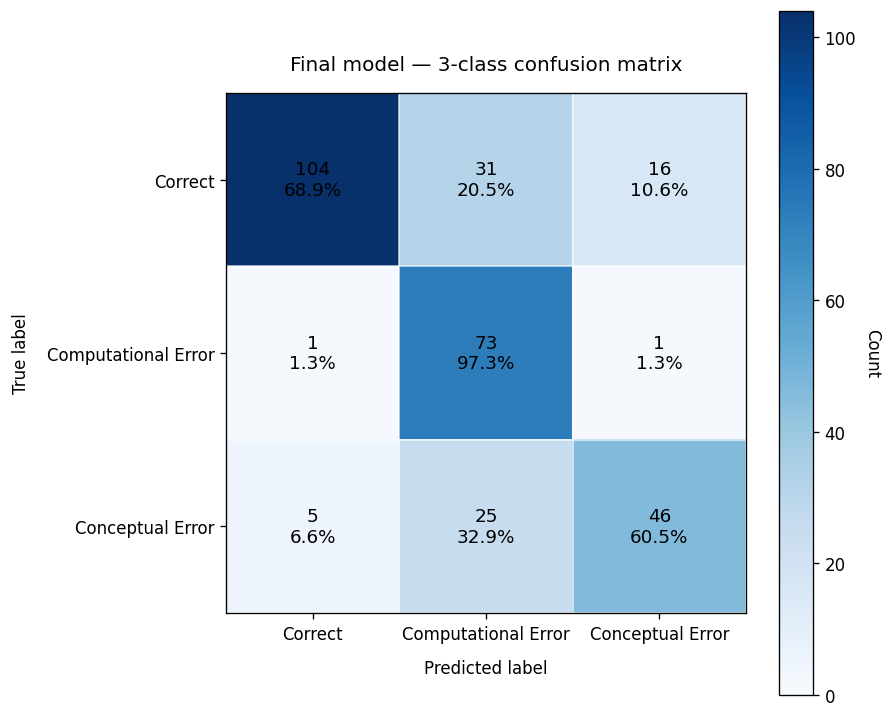

Dropped rows with missing labels: 0

Counts:
 Predicted label      Correct  Computational Error  Conceptual Error
True label                                                         
Correct                  104                   31                16
Computational Error        1                   73                 1
Conceptual Error           5                   25                46

Row %:
 Predicted label      Correct  Computational Error  Conceptual Error
True label                                                         
Correct                 68.9                 20.5              10.6
Computational Error      1.3                 97.3               1.3
Conceptual Error         6.6                 32.9              60.5


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- config ---
labels = ["Correct", "Computational Error", "Conceptual Error"]
title  = "Final model — 3-class confusion matrix"
save_path = "/content/confusion_matrix_3class.png"   # change or set to None

# --- prep data ---
df = evaluation_results_df.copy()
mask = df["true_label"].isin(labels) & df["predicted_classification"].isin(labels)
dropped = len(df) - mask.sum()
df = df[mask]

cm = pd.crosstab(
    df["true_label"], df["predicted_classification"],
    rownames=["True label"], colnames=["Predicted label"], dropna=False
).reindex(index=labels, columns=labels, fill_value=0)

# row-normalized percentages
cm_pct = (cm.div(cm.sum(axis=1).replace(0, 1), axis=0) * 100).round(1)

# --- plot ---
fig, ax = plt.subplots(figsize=(7.5, 6.5), dpi=120)
im = ax.imshow(cm.values, cmap="Blues", vmin=0)

# annotations: "count\nxx.x%"
for i in range(len(labels)):
    for j in range(len(labels)):
        count = cm.iat[i, j]
        pct   = cm_pct.iat[i, j]
        ax.text(j, i, f"{count}\n{pct:.1f}%", ha="center", va="center", fontsize=11)

# axes, ticks, labels
ax.set_xticks(np.arange(len(labels)), labels, rotation=0)
ax.set_yticks(np.arange(len(labels)), labels)
ax.set_xlabel("Predicted label", labelpad=10)
ax.set_ylabel("True label", labelpad=10)
ax.set_title(title, pad=14)

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=270, labelpad=15)

# grid lines for readability
ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
ax.grid(which="minor", color="white", linewidth=1, alpha=0.7)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
if save_path:
    plt.savefig(save_path, bbox_inches="tight")
plt.show()

print(f"Dropped rows with missing labels: {dropped}")
print("\nCounts:\n", cm)
print("\nRow %:\n", cm_pct)


In [ ]:
evaluation_results_df.columns

Index(['original_index', 'question', 'solution', 'true_label',
       'gemma_raw_output', 'extracted_json_str', 'predicted_classification',
       'pipeline_stage_stopped', 'phi4_correct_proba', 'phi4_flawed_proba',
       'phi4_raw_logits'],
      dtype='object')

## Debugging the equation extraction/evaluation process

There are (as seen in the confusion matrix above) a couple issues with our process.

* One is that many solutions are predicted to contain computational errors when
in fact they do not. We can actually see that this happens for most of the solutions predicted to contain computational errors. One cause of this is incorrect output by Gemma: essentially, hallucinated equations which are not in the original solution, and happen to be incorrect.

* The other one is that many solutions which do in fact contain computational errors are not detected. A cause of this is that Gemma misses these equations, or more commonly makes some formatting mistake when reporting them, which causes the function that parses Gemma's raw output and turns it into JSON to ignore the incorrect calculation.

In the following cells, we attempt to detect where and how the model and/or the parsing function is going wrong.

............................................

**In the next cell, we take a look at the solutions which contain computational errors but are not detected by the equation extraction/evaluation process (Stage 1).**

In [16]:
import pandas as pd
import json

df = evaluation_results_df  # rename if yours is different

# "Slipped through" = true comp error but Stage 1 did NOT stop the pipeline
slipped = df[
    (df["true_label"] == "Computational Error") &
    (df["pipeline_stage_stopped"] != 1)  # 2 means it went to Stage 2
].copy()


for i, row in slipped.iterrows():
    print("="*80)
    print(f"original_index: {row['original_index']} | predicted: {row['predicted_classification']}")
    print("- Question -")
    print(row["question"])
    print("\n- Solution -")
    print(row["solution"])
    print("\n- Gemma raw output -")
    print(row["gemma_raw_output"])
    print("\n- Extracted JSON (parsed) -")
    try:
        print(json.dumps(json.loads(row["extracted_json_str"]), indent=2))
    except Exception:
        print(row["extracted_json_str"])


original_index: 9 | predicted: Correct
- Question -
A train travels at a constant speed of 80 kilometers per hour. How long will it take to travel a distance of 360 kilometers?

- Solution -
The time taken is the distance divided by the speed: 360 / 80 = 4 hours.
FINAL ANSWER: 4

- Gemma raw output -
{
  "L1": "360/80=4",
  "FA": ""
}

- Extracted JSON (parsed) -
{
  "L1": "360/80=4",
  "FA": ""
}
original_index: 115 | predicted: Conceptual Error
- Question -
A small business owner's revenue was $120,000 in the first year. In the second year, it increased by 15%. In the third year, it decreased by 10% from the second year's revenue. The owner's profit margin is 25% of the revenue each year. What was the total profit over the three years?

- Solution -
Year 1 profit: 120000 * 0.25 = $30,000.
Year 2 revenue: 120000 * 1.15 = $138,000. Year 2 profit: 138000 * 0.25 = $32,500.
Year 3 revenue: 138000 * 0.90 = $124,200. Year 3 profit: 124200 * 0.25 = $31,050.
Total profit: $30,000 + $32,500 + 

**Now, we look at the correct solutions which were mistakenly classified as containing computational errors.**

In [17]:
import json
import pandas as pd

df = evaluation_results_df  # or rename if different

# False positives of Stage 1: true Correct → predicted Computational Error
fp_comp = df[
    (df["true_label"] == "Correct") &
    (df["predicted_classification"] == "Computational Error")
].copy()

print(f"Total 'Correct' samples: {(df['true_label']=='Correct').sum()}")
print(f"'Correct' misclassified as Computational Error: {len(fp_comp)}\n")

for _, row in fp_comp.iterrows():
    print("="*80)
    print(f"original_index: {row['original_index']} | predicted: {row['predicted_classification']}")
    print("- Question -")
    print(row["question"])
    print("\n- Solution -")
    print(row["solution"])
    print("\n- Gemma raw output -")
    print(row.get("gemma_raw_output", ""))
    print("\n- Extracted JSON (parsed) -")
    try:
        print(json.dumps(json.loads(row.get("extracted_json_str", "{}")), indent=2))
    except Exception:
        print(row.get("extracted_json_str", ""))


Total 'Correct' samples: 151
'Correct' misclassified as Computational Error: 31

original_index: 0 | predicted: Computational Error
- Question -
A community garden is rectangular and measures 15 meters in length and 10 meters in width. The gardeners decide to dedicate 20% of the garden's area to growing tomatoes. How many square meters are dedicated to growing tomatoes?

- Solution -
The total area of the garden is 15 * 10 = 150 square meters.
The area for tomatoes is 20% of the total area: 150 * 0.20 = 30 square meters.
FINAL ANSWER: 30

- Gemma raw output -
{
  "L1": "15*10=150",
  "L2": "20*10*0.20=30",
  "FA": ""
}

- Extracted JSON (parsed) -
{
  "L1": "15*10=150",
  "L2": "20*10*0.20=30",
  "FA": ""
}
original_index: 13 | predicted: Computational Error
- Question -
A car's fuel tank has a capacity of 50 liters. The car consumes 8 liters of fuel for every 100 kilometers driven. If the tank is full, how many kilometers can the car travel before the tank is empty?

- Solution -
The 